# What is about 

Compute growth (i.e. layer sizes) and make first analysis  of Cayley graphs for koltsov cycles and their Schreier coset graphs .


In [1]:
try :
    import numba
    # Use for CPU,GPU Kaggle machines:
    print('Install CayleyPy without dependencies (for Kaggle CPU,GPU):'); print()
    !pip install git+https://github.com/cayleypy/cayleypy --no-deps   
except :
    print('Install CayleyPy with dependencies (for Kaggle TPU):'); print()
    # Use for TPU kaggle machines - since no numba
    !pip install git+https://github.com/cayleypy/cayleypy
    


Install CayleyPy without dependencies (for Kaggle CPU,GPU):

Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/cayleypy/cayleypy to /tmp/pip-req-build-fcn1_nuf
  Running command git clone --filter=blob:none -q https://github.com/cayleypy/cayleypy /tmp/pip-req-build-fcn1_nuf
  Resolved https://github.com/cayleypy/cayleypy to commit 6298ae1d9d63fd6a48a6bd67517aacf98633805d
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
!pip install torch

Defaulting to user installation because normal site-packages is not writeable


In [3]:
import torch
import numpy as np 
import pandas as pd
torch.__version__

'2.9.1+cu128'

# Compute growth (i.e. layer sizes by BFS) -  wrapped consecutive_k_cycles Cayley graph

In [4]:
%%time 
import networkx as nx
from cayleypy import CayleyGraph, PermutationGroups
import re
import csv
import os
import time
import json


/home/ec2-user/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


CPU times: user 1.35 s, sys: 112 ms, total: 1.46 s
Wall time: 1.28 s


In [5]:
from sympy.combinatorics import Permutation, PermutationGroup
### Finding Cayley graph size with Schreier Sims alogrithms ###

def do_schreier_sims(gens):
    pgens = [Permutation(list(q)) for q in gens]
    G     = PermutationGroup(*pgens)
    return G.order()



In [6]:
### Saving to csv file
results_dir = "./results"
os.makedirs(results_dir, exist_ok=True)

csv_filename = os.path.join(results_dir, "koltsov3_4different_perm2_results.csv")
# Create file + header if it doesn't exist
write_header = not os.path.exists(csv_filename)

csv_file = open(csv_filename, "a", newline="")
csv_writer = csv.writer(csv_file)


if write_header:
    csv_writer.writerow([
        "k_param",
        # "d_param",
        "perm_type",
        "coset",
        "n_values",
        "diameters",
        "last_layers",
        "total_states",
        "num_n_computed",
    ])
    csv_file.flush()


In [ ]:
%%time

max_n = 40
# diams = []
# dict_diams = {}
# last_layers = []

dict_growth = dict()
dict_last_layer = dict()


# ----------------------------
# Soft timeout settings
# ----------------------------
TIME_LIMIT_SEC = 30.0          # mark run as "slow" if BFS+SS exceeds this
STOP_ON_SLOW = True            # if True, stop the whole sweep once a slow run happens
MAX_SLOW_RUNS = 5              # if STOP_ON_SLOW is False, optionally stop after many slow runs
slow_runs = 0


#Koltsov graph params
# 3 generators:
# I generator swaps even elements - (0,1), (2,3),...
# K generator swaps odd elements - (1,2), (3,4),...
# S - special swap generator pattern controlled by params
perm_type = 2  # 1 - 1 transpostion (k, k + d), or 2 - product of 2 transpositions (k, k+3) and (k+1, k+2)
k = 2         # starting index of S, window must be within size n (length of permutation)
d = 1         # distance of S, additional param for perm_type=1

# Graph definition:
# Part 1 -- generators: 
graph_name_part1 = 'Koltsov3'

# Part 2 -- Coset or not:
list_options = [' Coset', '']
graph_name_part2 = list_options[0]

# Part 3 -- specify what coset:
graph_name_part3 = ''
if graph_name_part2 == ' Coset':
    # Central state is repeats of some block e.g. [0,1]ˆ(n//2)
    # graph_name_part4 = ' Binary01Repeats' # central = [0,1]*(n//2) + [0]*(n - 2*(n//2) )
    # graph_name_part4 = ' Binary01Repeats_1' # central = [0,1]*(n//2) + [1]*(n - 2*(n//2) )
    # graph_name_part4 = ' 012Repeats' # [0,1,2]*(n//3)+[0,1,2][:(n%3)]
    # graph_name_part4 = ' 011Repeats' # [0,1,1]*(n//3)+[0,1,1][:(n%3)]

    # # # Central state - like 0..01..12...23...
    # graph_name_part4 = ' Binary0then1'
    # graph_name_part4 = ' 0then1then2'
    # graph_name_part4 = ' 0then1then2then3'
    # graph_name_part4 = ' 0then1then2then3then4'

    # # Central state - like 0123..n-k,n-k,n-k (Several last - coincide)
    # graph_name_part4 = ' 2Coincide' #  (0,1,2,3...,n-2,n-2)
    # graph_name_part4 = ' 3Coincide' #  (0,1,2,3...,n-3,n-3,n-3)
    # graph_name_part4 = ' 4Coincide' # 
    # graph_name_part4 = ' 5Coincide' #     
    # graph_name_part4 = ' 6Coincide' #     
    
    # # Central state - like 01XXXXXXXX, i.e. almost all coincide except 
    #graph_name_part4 = ' 2Different' # 0111...1111
    #graph_name_part4 = ' 3Different' # 0122...2222
    # graph_name_part3 = ' 4Different' # 01233...333  
    graph_name_part3 = 'full_graph'
    
graph_name = graph_name_part1+graph_name_part2+graph_name_part3



print('Graph:', graph_name )

for k in range(0,20):
    # for d in range(1,16):
    # print('k = {k}, d = {d}'.format(k=k, d=d))

    # --- NEW: aggregators for this (k,d,perm_type) ---
    n_values = []
    diam_by_n = {}      # {n: diameter}
    states_by_n = {}    # {n: total_states}
    last_layers_by_n = {}  # {n: last_layer}

    start_n = k + 4 if perm_type == 2 else k + d + 1
    if start_n > max_n:
        continue

    for n in range(start_n,max_n + 1):
    # for n in [36]:

        if 'Koltsov3' in graph_name:
            defn = PermutationGroups.koltsov3(n, perm_type=perm_type, k=k, d=d)
        else:
            print('Unknown type of generators')
            raise Exception("Unknown type of generators")
            
        if 'Coset' in graph_name:
            if 'Different' in graph_name:
                match = re.search(r"(\d+)(?=Different)", graph_name)
                D = int(match.group(1))
            
                # Invalid regime — skip
                if n < D:
                    continue
            
                central = list(range(D-1)) + [D-1] * (n - (D-1))
            elif 'Binary01Repeats_1' in graph_name:
                central = [0,1]*(n//2) + [1]*(n - 2*(n//2) )
            elif 'Binary01Repeats' in graph_name:
                central = [0,1]*(n//2) + [0]*(n - 2*(n//2) ) 
            elif 'Repeats' in graph_name:
                # Extract the repeating block:
                match = re.search(r"(\d+)(?=Repeats)", graph_name)
                lst = [int(char) for char in match.group(1)]
                len_str = len(lst)
                central = lst*(n//len_str) + lst[ :(n % len_str) ]
            elif '0then1then2then3then4' in graph_name:
                central = [0]*(n//5) +  [1]*(n//5) + [2]*(n//5) + [3]*(n//5) +  [4]*(n - 4*(n//5) ) 
            elif '0then1then2then3' in graph_name:
                central = [0]*(n//4) +  [1]*(n//4) + [2]*(n//4) +   [3]*(n - 4*(n//4) ) 
            elif '0then1then2' in graph_name:
                central = [0]*(n//3) +  [1]*(n//3) +  [2]*(n - 2*(n//3) ) 
            elif 'Binary0then1' in graph_name:
                central = [0]*(n//2) + [1]*(n - n//2)
            elif 'Coincide' in graph_name:
                match = re.search(r"(\d+)(?=Coincide)", graph_name)
                n_coincide = int(match.group(1))
                #print(n, n_coincide)
                central = list(range(n-n_coincide)) + [n-n_coincide]*n_coincide
                
            print('central:', central)
            if len( np.unique( central )) == 1: continue 
                
            defn = defn.with_central_state(central)
            
        t0 = time.time()
        graph = CayleyGraph(defn)
        total_states = do_schreier_sims(graph.generators)
        result = graph.bfs(return_all_edges=False, return_all_hashes=False)
        diameter = result.diameter()
        elapsed = time.time() - t0

        is_slow = (elapsed > TIME_LIMIT_SEC)

        if is_slow:
            slow_runs += 1
            print(f"⏱️ SLOW RUN: k={k}, d={d}, n={n} took {elapsed:.2f}s (limit {TIME_LIMIT_SEC}s)")

            if STOP_ON_SLOW:
                print("Stopping sweep due to STOP_ON_SLOW=True")
                raise SystemExit

            if slow_runs >= MAX_SLOW_RUNS:
                print(f"Stopping sweep after {slow_runs} slow runs (MAX_SLOW_RUNS={MAX_SLOW_RUNS})")
                raise SystemExit


        n_values.append(n)
        diam_by_n[n] = diameter
        states_by_n[n] = total_states
        last_layers_by_n[n] = len(result.last_layer())


        # diams.append(result.diameter())
        # dict_diams[n] = result.diameter()
        last_layers.append(result.last_layer())
        print(f"n={n}, Bfs result:{result}\n")
        # dict_key = graph_name+'|'+str(k)+'|'+str(n) 
        # dict_growth[dict_key] = result.layer_sizes
        # dict_last_layer[dict_key] = result.last_layer()[:10000].tolist()

        # Writing to CSV
        # if 'Coset' in graph_name:
        #     coset_label = graph_name_part3.strip()  # e.g. "4Different"
        # else:
        #     coset_label = "FullGraph"

        # diameter = result.diameter()
        # growth = result.layer_sizes
        # last_layer_size = len(result.last_layer())

        # csv_writer.writerow([
        #     coset_label,
        #     d,
        #     k,
        #     n,
        #     diameter,
        #     last_layer_size,
        #     total_states,
        #     str(list(growth))   # IMPORTANT: stringify list
        # ])

        # csv_file.flush()

    # --- NEW: write exactly ONE row per (k,d,perm_type[,coset]) ---
    # csv_writer.writerow([
    #     k,
    #     # d,
    #     perm_type,
    #     coset_label,
    #     json.dumps(n_values),        # safer than str(list(...)) for CSV
    #     json.dumps(diam_by_n),       # dict {n:diam}
    #     json.dumps(last_layers_by_n),# dict {n:last_layer}
    #     json.dumps(states_by_n),     # dict {n:states}
    #     len(n_values)
    # ])
    # csv_file.flush()

# csv_file.close()

Graph: Koltsov3 Coset 4Different
central: [0, 1, 2, 3]


CPU times: user 156 ms, sys: 327 ms, total: 483 ms
Wall time: 496 ms


NameError: name 'last_layers' is not defined

In [ ]:
print(dict_diams)

{4: 4, 5: 8, 6: 7, 7: 17, 8: 22, 9: 12, 10: 31, 11: 36, 12: 18, 13: 46, 14: 50, 15: 24, 16: 60, 17: 64, 18: 30, 19: 74, 20: 80, 21: 35, 22: 91, 23: 97, 24: 42, 25: 108, 26: 114, 27: 48, 28: 125, 29: 131, 30: 53}


In [ ]:
import json

id_rand = np.random.randint(1, 100000) 
# Save dictionary to JSON file
fname = "dict_growth_"+str(id_rand)+".json"
with open(fname, "w") as f:
    json.dump(dict_growth, f, indent=4)  # indent makes it readable

fname = "dict_last_layer_"+str(id_rand)+".json"
with open(fname, "w") as f:
    json.dump(dict_last_layer, f, indent=4)  # indent makes it readable

In [ ]:
for ids in dict_last_layer:
    last_layer = dict_last_layer[ids]
    gname = ids.split('|')[0]
    n = ids.split('|')[-1]
    print('n=',n, )
    print('last_layer:')
    print(np.array(last_layer) )

n= 4
last_layer:
[[3 2 1 0]
 [2 3 1 0]
 [2 1 3 0]
 [1 2 3 0]
 [3 2 0 1]
 [3 1 0 2]
 [3 0 1 2]
 [2 1 0 3]]
n= 5
last_layer:
[[2 1 3 3 0]
 [2 0 3 3 1]
 [1 0 3 3 2]
 [0 1 3 3 2]]
n= 6
last_layer:
[[3 3 2 3 1 0]]
n= 7
last_layer:
[[2 3 3 3 3 1 0]
 [3 2 3 3 1 3 0]]
n= 8
last_layer:
[[2 3 3 3 3 1 0 3]]
n= 9
last_layer:
[[3 3 3 3 2 1 3 3 0]
 [3 3 3 3 2 0 3 3 1]]
n= 10
last_layer:
[[2 3 3 3 3 1 0 3 3 3]
 [1 3 3 3 3 2 0 3 3 3]
 [2 3 3 3 3 0 1 3 3 3]
 [0 3 3 3 3 2 1 3 3 3]]
n= 11
last_layer:
[[2 3 3 3 3 1 0 3 3 3 3]
 [2 3 3 3 3 0 1 3 3 3 3]]
n= 12
last_layer:
[[2 3 3 3 3 3 3 1 0 3 3 3]]
n= 13
last_layer:
[[2 3 3 3 3 1 0 3 3 3 3 3 3]
 [2 3 3 3 3 0 1 3 3 3 3 3 3]]
n= 14
last_layer:
[[2 3 3 3 3 1 0 3 3 3 3 3 3 3]
 [2 3 3 3 3 0 1 3 3 3 3 3 3 3]
 [1 3 3 3 3 0 2 3 3 3 3 3 3 3]
 [0 3 3 3 3 1 2 3 3 3 3 3 3 3]]
n= 15
last_layer:
[[3 3 3 3 3 3 2 1 3 3 3 3 3 3 0]
 [3 3 3 3 3 3 2 0 3 3 3 3 3 3 1]]
n= 16
last_layer:
[[2 3 3 3 3 1 0 3 3 3 3 3 3 3 3 3]
 [2 3 3 3 3 0 1 3 3 3 3 3 3 3 3 3]
 [1 3 3 3 3 0 2 3 3 3 3

# Plot diameters 

Fit full data:
coefs: nˆ2 , n, nˆ0 [ -0.02167909   4.54722327 -16.87048966]
coefs inverse: nˆ2 , n, nˆ0 -46.127403379296965 0.219914426797505 -0.0592751022608445
Fit on last 50 of data:
coefs: nˆ2 , n, nˆ0 [  -0.61288711   33.25924076 -357.54145854]
coefs inverse: nˆ2 , n, nˆ0 -1.631621841890779 0.030066831869039367 -0.0027968784489478646


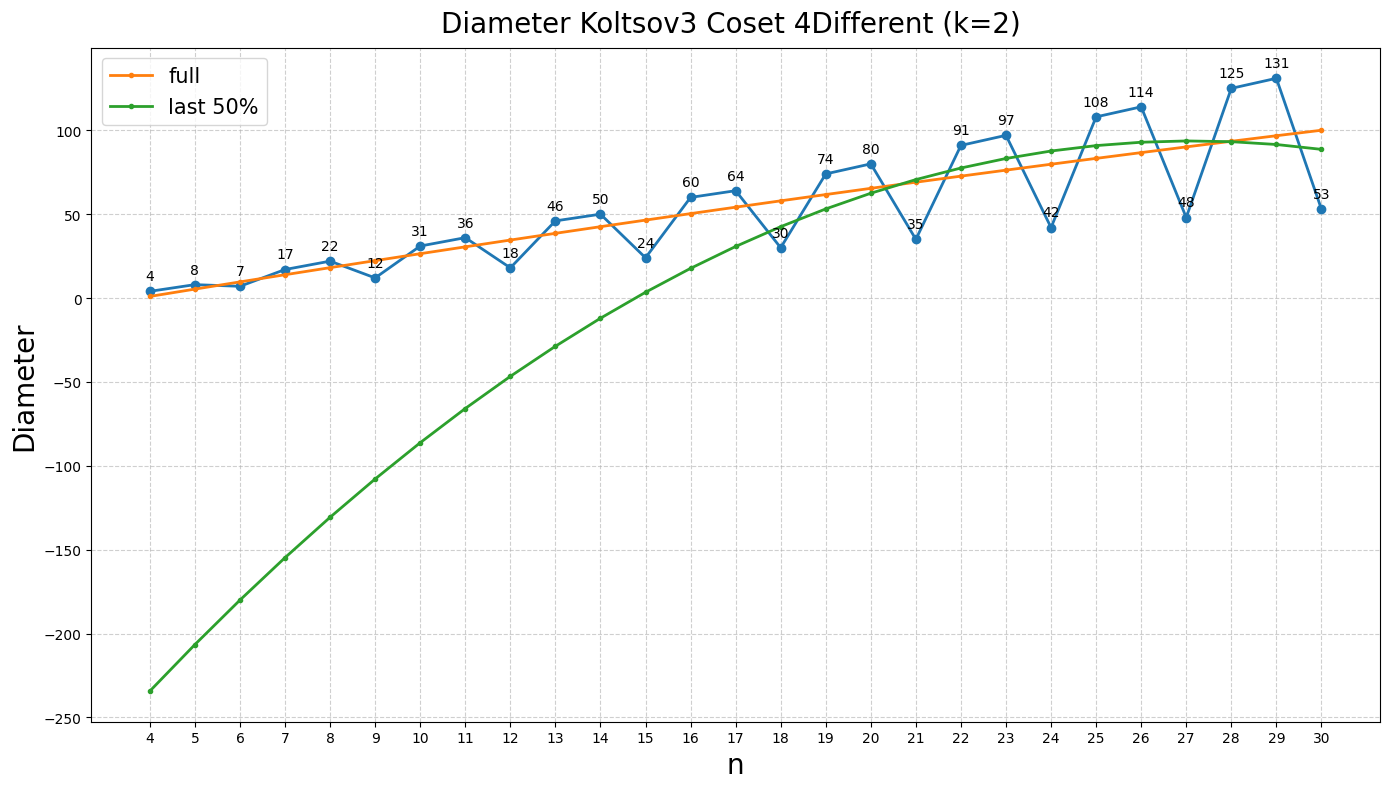

/tmp/ipykernel_449253/291737269.py:39: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize = 15)


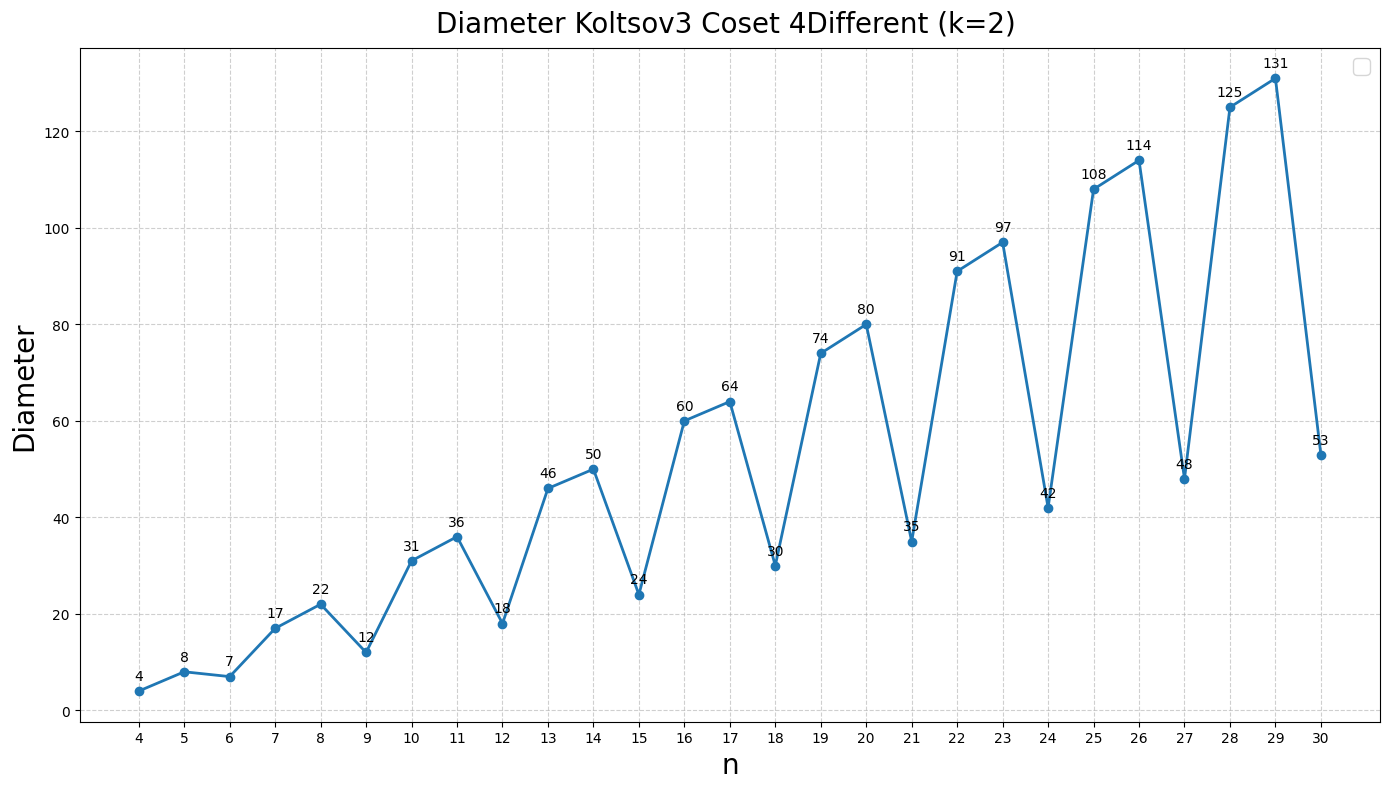

In [ ]:
import matplotlib.pyplot as plt

# start_n = k+1
ns = list( dict_diams.keys() )
diams_loc = list( dict_diams.values() )

# y_approx1 = np.array(ns)**2/(4*(k-1))
# y_approx2 = np.array(ns)**2/(2*(k-1))

pol = np.polyfit(ns, diams_loc, 2)
print('Fit full data:')
print('coefs: nˆ2 , n, nˆ0', pol)
print('coefs inverse: nˆ2 , n, nˆ0', 1/pol[0],1/pol[1],1/pol[2])
y_approx3 = np.polyval(pol, ns)

percent_fit = 50
print(f'Fit on last {percent_fit} of data:')
ss = int(len(ns)*percent_fit/100)
pol = np.polyfit(ns[-ss:], diams_loc[-ss:], 2)
print('coefs: nˆ2 , n, nˆ0', pol)
print('coefs inverse: nˆ2 , n, nˆ0', 1/pol[0],1/pol[1],1/pol[2])
y_approx4 = np.polyval(pol, ns)

for tmp in [0,1]: # Repeat plot twice - with approximation and without
    
    plt.figure(figsize=(14,8))
    plt.plot(ns, diams_loc, marker='o', linewidth=2)

    if tmp == 0:
        # plt.plot(ns, y_approx1, marker='.', linewidth=2)
        # plt.plot(ns, y_approx2, marker='.', linewidth=2)
        plt.plot(ns, y_approx3, marker='.', linewidth=2, label = 'full')
        plt.plot(ns, y_approx4, marker='.', linewidth=2, label = 'last '+str(percent_fit) +'%')
    
    plt.title(f"Diameter {graph_name} (perm_type={perm_type}, k={k}, d={d}) ", fontsize=20, pad=12)
    plt.xlabel("n", fontsize=20)
    plt.ylabel("Diameter", fontsize=20)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(fontsize = 15)
    plt.xticks(ns)
    
    for x, y in zip(ns, diams_loc):
        plt.annotate(str(y), (x, y), textcoords="offset points", xytext=(0, 8), ha="center", fontsize=10)
    
    plt.tight_layout()
    plt.show()


In [ ]:
diams

[4,
 8,
 7,
 17,
 22,
 12,
 31,
 36,
 18,
 46,
 50,
 24,
 60,
 64,
 30,
 74,
 80,
 35,
 91,
 97,
 42,
 108,
 114,
 48,
 125,
 131,
 53]

# Plot growths

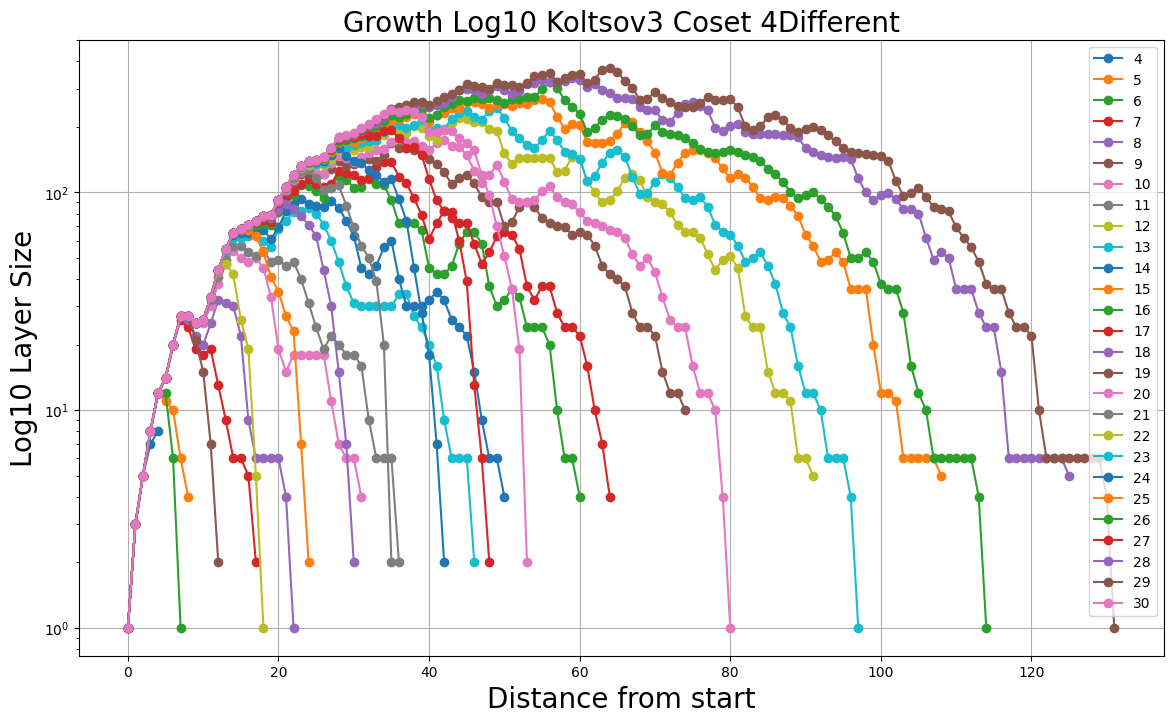

In [ ]:
plt.figure(figsize=(14, 8))

for ids in dict_growth:
    vec_growth = dict_growth[ids]
    
    gname = ids.split('|')[0]
    n = ids.split('|')[-1]
    plt.semilogy(vec_growth,'o-', label = n )

str_inf = "Growth Log10 "+gname
plt.title(str_inf , fontsize=20)
plt.xlabel('Distance from start', fontsize=20)
plt.ylabel('Log10 Layer Size', fontsize=20)
plt.legend()
plt.grid()
plt.show()

    

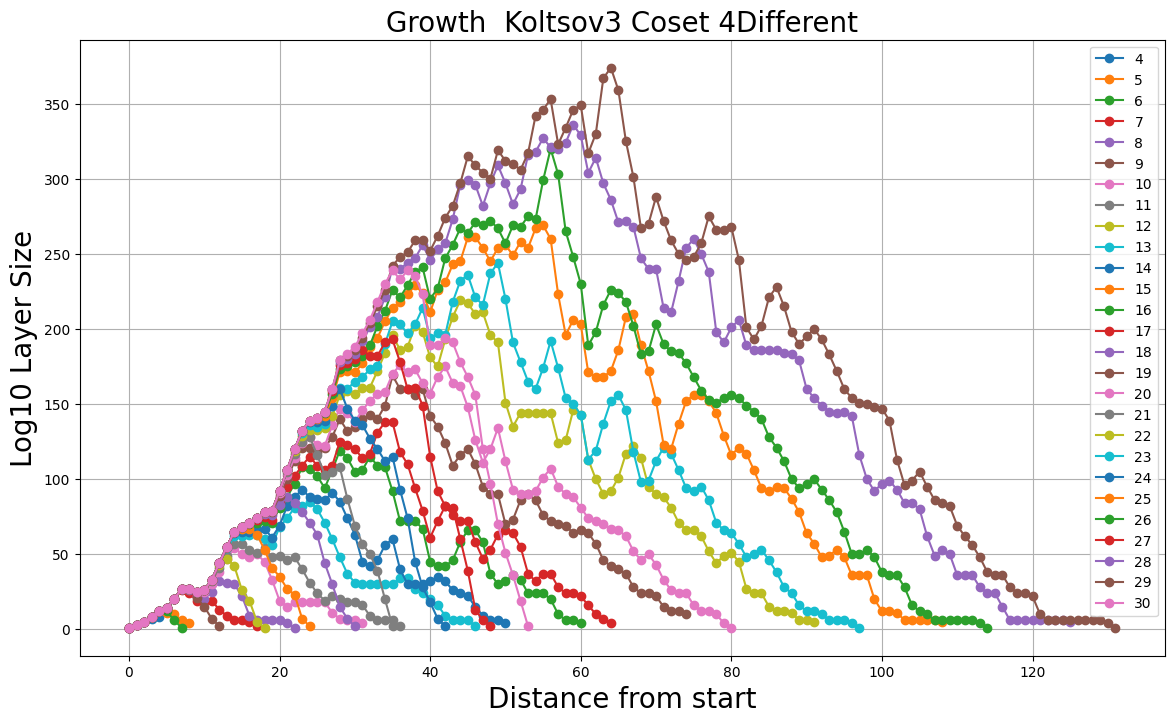

In [ ]:
plt.figure(figsize=(14, 8))

for ids in dict_growth:
    vec_growth = dict_growth[ids]
    gname = ids.split('|')[0]
    n = ids.split('|')[-1]
    plt.plot(vec_growth,'o-', label = n )

str_inf = "Growth  "+ gname
plt.title(str_inf , fontsize=20)
plt.xlabel('Distance from start', fontsize=20)
plt.ylabel('Log10 Layer Size', fontsize=20)
plt.legend()
plt.grid()
plt.show()

# Plot Last layers sizes 

/tmp/ipykernel_449253/1774795513.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


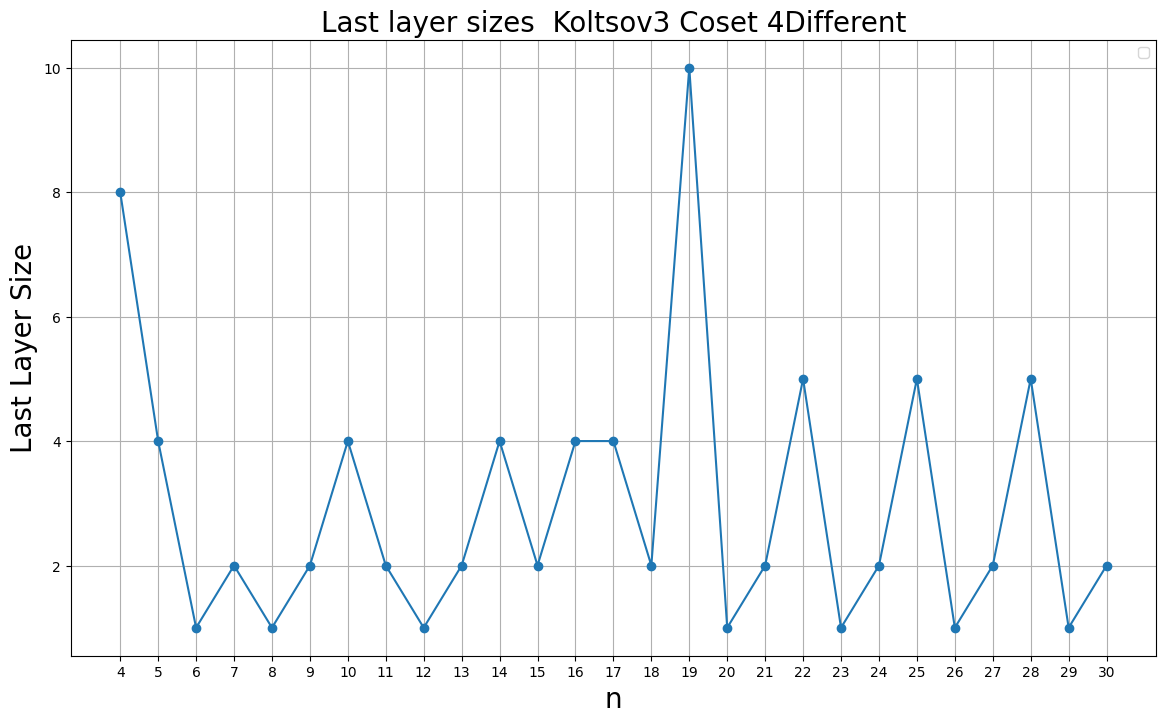

,last layer size
n,
4,8
5,4
6,1
7,2
8,1
9,2
10,4
11,2
12,1


[8, 4, 1, 2, 1, 2, 4, 2, 1, 2, 4, 2, 4, 4, 2, 10, 1, 2, 5, 1, 2, 5, 1, 2, 5, 1, 2]


In [ ]:
plt.figure(figsize=(14, 8))

x = []
y = []
for ids in dict_last_layer:
    last_layer = dict_last_layer[ids]
    gname = ids.split('|')[0]
    n = ids.split('|')[-1]
    x.append(n)
    y.append(len(last_layer))
plt.plot(x,y,'o-'  )

str_inf = "Last layer sizes  "+ gname
plt.title(str_inf , fontsize=20)
plt.xlabel('n', fontsize=20)
plt.ylabel('Last Layer Size', fontsize=20)
plt.legend()
plt.grid()
plt.show()
df1 = pd.DataFrame()
df1['n'] = x 
df1 = df1.set_index('n')
df1['last layer size'] = y 
display(df1)
df1.to_csv('last_layer_sizes.csv')
print(y)